# H4 Vias And H4 EAD Processing Time Stats

I applied for H4 visa and H4 EAD this Apr. While waiting, I decided to find the stats for H4 visa/EAD processing time.

In [3]:
## Scrape data from http://www.trackitt.com
from bs4 import BeautifulSoup
import requests
import json

s = requests.Session()

def get_page(page_number):
    r = s.get("http://www.trackitt.com/usa-immigration-trackers/h4-ead/page/" + str(page_number))
    return get_data(r.text)

def get_data(file_name):
    soup = BeautifulSoup(file_name, "html.parser")
    datas = []
    for row in soup.findAll("tr", {"class" : ["regulartrackerrow", "certifiedtrackerrow"]}):
        data = {}
        columns = row.findAll("td")
        data["name"] = columns[1].text
        data["nationality"] = columns[3].text
        data["application_type"] = columns[4].text
        data["service_center"] = columns[5].text
        data["filed_date"] = columns[7].text
        data["received_date"] = columns[8].text
        data["notice_date"] = columns[9].text
        data["ref_received"] = columns[11].text
        data["application_status"] = columns[15].text
        data["approval_denial_date"] = columns[16].text
        data["ead_ordered_date"] = columns[17].text
        data["ead_received_date"] = columns[18].text
        data["total_processing_time"] = columns[19].text
        data["days_elapsed"] = columns[21].text
        data["note"] = columns[22].text
        detailed_link = columns[22].find("a")
        if detailed_link:
            data["note2"] = detailed_link['title']
        else:
            data["note2"] = ""
            
        datas.append(data)
    return datas

all_datas = []
for i in range(1, 59):
    all_datas.extend(get_page(i))

In [4]:
# Convert all the date from string to datetime and calculate total processing time
import numpy as np
import pandas as pd
from pandas import DataFrame

df = DataFrame.from_records(all_datas)

data_column_names = ['filed_date', 'notice_date', 'received_date', 'approval_denial_date', 'ead_ordered_date', 'ead_received_date']
for column_name in data_column_names:
    df[column_name] = pd.to_datetime(df[column_name], format='%m/%d/%Y', errors='coerce')

df['total_processing_days'] = (df['approval_denial_date'] - df['filed_date']).dt.days

# Find some negative value of total_processing_days. Drop them.
df = df[df.total_processing_days > 0]

# Combine note2 and note to processed_note.
df['processed_note'] = np.where(df['note2'] != '', df['note2'], df['note'])
df['processed_note'] = df['processed_note'].str.lower()

## Summary

Overall, median processing time is 57 days, but some application might take up to one year.

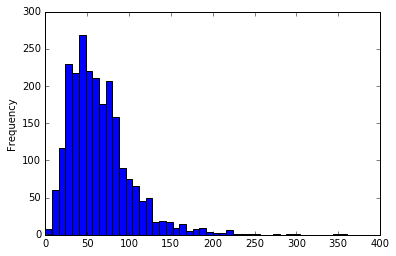

In [5]:
import matplotlib
%matplotlib inline

df['total_processing_days'].plot.hist(bins=50,range=(0,400))

In [6]:
df['total_processing_days'].describe()

count    2317.000000
mean       63.788088
std        37.608191
min         3.000000
25%        37.000000
50%        57.000000
75%        81.000000
max       355.000000
Name: total_processing_days, dtype: float64

## How to get approve fast

1. Premium process can lower processing time by 3~4 weeks.

In [7]:
df[df['processed_note'].str.contains('premium')]['total_processing_days'].describe()

count     60.000000
mean      47.333333
std       42.974437
min        3.000000
25%       11.000000
50%       30.500000
75%       79.500000
max      175.000000
Name: total_processing_days, dtype: float64

In [8]:
df['application_type'].unique()

array([u'new application', u'renewal'], dtype=object)

In [9]:
df[~df['processed_note'].str.contains('premium') & df['application_type'].str.match('new application')]['total_processing_days'].describe()

count    2163.000000
mean       64.407767
std        37.574609
min         8.000000
25%        38.000000
50%        57.000000
75%        81.000000
max       355.000000
Name: total_processing_days, dtype: float64

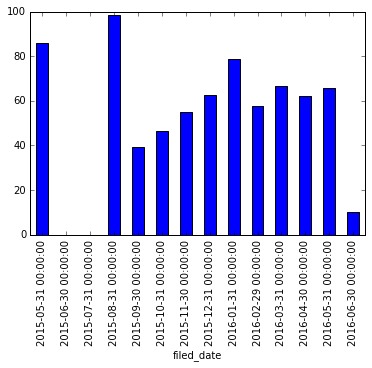

In [10]:
new_app_no_premium = df[~df['processed_note'].str.contains('premium') & 
   df['application_type'].str.match('renewal')]
new_app_no_premium = new_app_no_premium.set_index('filed_date')
new_app_no_premium
new_app_no_premium.groupby(pd.TimeGrouper(freq='M'))['total_processing_days'].mean().plot.bar()

In [11]:
df[~df['processed_note'].str.contains('premium') & 
   df['application_type'].str.match('new application')][['total_processing_days', 'processed_note']]

,total_processing_days,processed_note
0,291.0,
1,71.0,
2,96.0,
3,105.0,approved on the same day that my h4 extension ...
4,99.0,case was sent to dallas - was routed to vermon...
6,88.0,standalone h4ead
10,75.0,
11,87.0,
12,132.0,"hi all, i filed opttoh4 and h4 ead application..."
18,93.0,received the ead card on 21st july..


In [12]:
df[~df['processed_note'].str.contains('premium') & df['application_type'].str.match('renewal')]['total_processing_days'].describe()

count     94.000000
mean      60.031915
std       32.113526
min        7.000000
25%       38.000000
50%       58.000000
75%       74.750000
max      185.000000
Name: total_processing_days, dtype: float64

In [13]:
# Many applications that approved within 10 days are filed with h1 concurrently.
df[df['total_processing_days'] < 10]['processed_note']

280     filled concurrently with h1 b, h4  and h4 ead ...
289                                                      
357     h1 extension + h4 extension + h4 ead renewal -...
389     we submitted 3 applications together on may 03...
430             h1/h4 extension and h4-ead premium filing
462                                               premium
487     f1 to h4 cos (under h1 premium); h4 ead filed ...
547           applied with h1, h4 etxn premium processing
571     ead renewal, no major changes in circumstances...
650     filed  h1b +h4 ext  and h4 ead   together in p...
747     concurrent filing -  h1b + h4 + h4 ead extensions
803     h1 extension primary (premium) + h1 to h4 cos ...
814     this is the case filed by my lawyer along with...
982     h1 eos + h4 cos and ead applied in premium. no...
1394                                                     
1404    concurrent filing of h1 , h4 extension along w...
1816                                                     
1851          

In [14]:
df[df['processed_note'].str.contains('h1') & df['processed_note'].str.contains('concurrent')]['total_processing_days'].describe()

count     56.000000
mean      92.857143
std       61.447517
min        6.000000
25%       50.000000
50%       86.500000
75%      119.250000
max      302.000000
Name: total_processing_days, dtype: float64

In [16]:
df[df['application_type'] == 'new application']['total_processing_days'].describe()

count    2207.000000
mean       64.027639
std        37.730346
min         3.000000
25%        37.000000
50%        57.000000
75%        81.000000
max       355.000000
Name: total_processing_days, dtype: float64

In [17]:
df.groupby('service_center').mean()

,total_processing_days
service_center,
California,54.340000
Dallas,67.345865
Nebraska,46.000000
Phoenix,48.650165
Texas,63.965517
Vermont,73.867481


In [18]:
df.groupby('nationality').mean()

,total_processing_days
nationality,
\nCanada,65.428571
\nChina,66.675000
\nFrance,53.000000
\nGuyana,92.000000
\nIndia,63.297745
\nPakistan,74.000000
\nPhilippines,100.500000
\nSingapore,83.000000
\nSweden,101.000000


## Output for Javascript

In [21]:
## total_processing_days, application_type, service_center, premium

df['premium'] = df['processed_note'].str.contains('premium')
jsdata = df[['total_processing_days', 'premium', 'application_type', 'service_center']]
jsdata.to_csv('data.csv', index=False)